In [1]:
%load_ext autoreload
%autoreload 2


import os
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sps
import matplotlib.pyplot as plt

import sys
from os.path import join
from pathlib import Path
cur_dir = Path(os.getcwd())
sys.path.append(str(cur_dir.parent.absolute()))
from sklearn.preprocessing import normalize

from GLOBE.builder import GLOBE
from GLOBE.config import Config
from GLOBE.trainval import get_args

from GLOBE.prepare_dataset import prepare_dataset, prepare_mnn
from GLOBE.preprocessing import preprocess_data, embPipe, hvgPipe

configs = Config()

In [2]:
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

args_dict = {"exp_id": 'Neocortex_0523',
            "mode": 'unsupervised', 
            "dname": "Neocortex",
             
            # pp params
            "select_hvg": True,
            "scale": False, 
             
            # network params 
            "block_level": 1,
            "lat_dim": 128,
            "proj_dim":64,
            "header":None,
            "init": 'uniform',
             
            # training params
            "use_knn": False,
            "add_noise": False,    # wheter to add noise for positives
            "loss_type": 'GLOBE',  # GLOBE or InfoNCE
            "temp": 0.1,
            "load_ckpt": False,
            "ckpt_idx": 2,
            "sup_eps": 100,
            "sup_lr": 1e-4,
            'unsup_eps': 80,
            "unsup_lr": 1e-5,
            "weight_decay":1e-4,
            "batch_size": 256,
            "plot_loss": True,
            "save_freq": 10,
            "gpu": '0',
            "num_workers": 6}

args = Struct(**args_dict)
args.lr = args.sup_lr if args.mode=='supervised' else args.unsup_lr
args.eps= args.sup_eps if args.mode=='supervised' else args.unsup_eps
args.mode = args.mode + '-' + args.loss_type  # to be optimized

In [3]:
# prepare dataset
sps_x, genes, cells, metadata = prepare_dataset(join(configs.data_root, args.dname))
anchor_data = prepare_mnn(join(configs.data_root, args.dname))  # loading anchors exported from seurat

# preprocessing
sps_x, pp_genes, pp_cells, pp_metadata, pp_anchor_data = preprocess_data(sps_x, 
                                                            cnames=cells, 
                                                            gnames=genes, 
                                                            metadata=metadata, 
                                                            anchor_data=anchor_data,
                                                            select_hvg=args.select_hvg, 
                                                            scale=args.scale)

reading Anchors from  /home/yxh/gitrepo/Batch-effect-removal-benchmarking-master/Script/sapling/GLOBE/data/Neocortex/seuratAnchors.csv


... storing 'CellType' as categorical
... storing 'batchlb' as categorical
/home/yxh/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [4]:
sps_x.shape, pp_genes.shape, pp_cells.shape, pp_metadata.shape

((16651, 2000), (2000,), (16651,), (16651, 2))

In [5]:
# init model
globe = GLOBE(
        mode=args.mode,          # supervised or unsupervised
        exp_id=args.exp_id,
        gpu=args.gpu,
    )

In [6]:
# create dataset and loader
globe.build_dataset(
    sps_x=sps_x, 
    gnames=pp_genes, 
    cnames=pp_cells, 
    metadata=pp_metadata, 
    anchor_data=pp_anchor_data,
    add_noise=args.add_noise,
    use_knn=args.use_knn
)

# initializing network
globe.build_model(
    lat_dim=args.lat_dim,
    proj_dim=args.proj_dim,
    header=args.header,
    block_level=args.block_level,
    init=args.init
)

building dataset
building model


100%|██████████| 66/66 [00:01<00:00, 39.47batch/s, loss=1.46]


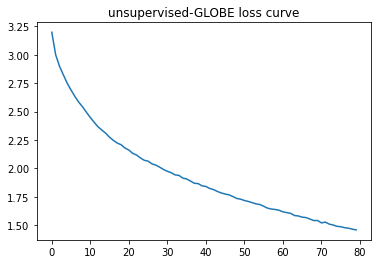

In [7]:
# training
globe.train(
    temp=args.temp,
    lr=args.lr,
    batch_size=args.batch_size,
    epochs=args.eps,
    plot_loss=args.plot_loss,
    save_freq=args.save_freq,
    weight_decay=args.weight_decay,
    num_workers=args.num_workers,
)

=> loaded unsupervised-GLOBE checkpoint 30
=> gene integrated


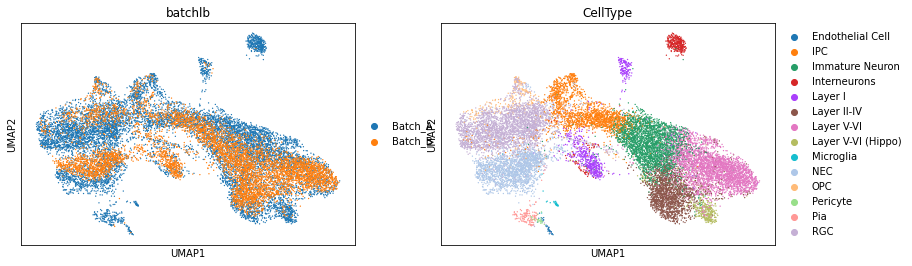

In [8]:
globe.load_ckpt(30)
lat_data, prj_data, metadata1 = globe.evaluate(batch_size=args.batch_size, num_workers=args.num_workers)
prj_data = normalize(lat_data, axis=1)

dec_rec, dec_metas = globe.integrate_gene(rec=prj_data, knn=20, sigma=0.001, alpha=0.1) # 
ad_g = hvgPipe(dec_rec, dec_metas, scale=False)
sc.pl.umap(ad_g, color=[configs.batch_key, configs.label_key])

# import Raw data

In [9]:
from GLOBE.prepare_dataset import prepare_dataset
X, gene_name, cell_name, df_meta = prepare_dataset(join(configs.data_root, 'Neocortex'))
X = X.T

adata_raw = sc.AnnData(X)
adata_raw.obs_names = cell_name
adata_raw.var_names = gene_name

adata_raw.obs = df_meta

sc.pp.filter_genes(adata_raw, min_cells=3) 
sc.pp.normalize_total(adata_raw, target_sum=1e4)
sc.pp.log1p(adata_raw)

adata_raw.X = adata_raw.X.A   # to speed up

sc.pp.scale(adata_raw, max_value=10)   # X -> array
sc.pp.pca(adata_raw, n_comps=50) # svd_solver='arpack' not accept sparse input

sc.pp.neighbors(adata_raw, n_neighbors=15, n_pcs=50)

sc.tl.umap(adata_raw)

... storing 'CellType' as categorical
... storing 'batchlb' as categorical


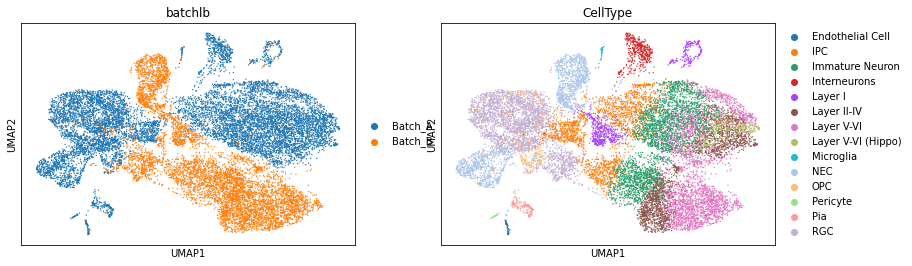

In [10]:
sc.pl.umap(adata_raw, color=[configs.batch_key, configs.label_key])

# split data into two batches

In [11]:
a_idx = (df_meta.batchlb == 'Batch_A').values
adata_r_a = sc.AnnData(X[a_idx])
adata_r_a.obs_names = np.array(cell_name)[a_idx]
adata_r_a.var_names = gene_name

b_idx = df_meta.batchlb == 'Batch_B'
adata_r_b = sc.AnnData(X[b_idx])
adata_r_b.obs_names = np.array(cell_name)[b_idx]
adata_r_b.var_names = gene_name

adata_r_a.obs = df_meta.loc[a_idx]
adata_r_b.obs = df_meta.loc[b_idx]

def prep(adata, hvg=None):
    sc.pp.filter_genes(adata, min_cells=0) 
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    if hvg:
        sc.pp.highly_variable_genes(adata, n_top_genes=min(adata.shape[1], hvg), 
#                                 min_mean=0.0125, max_mean=3, min_disp=0.5,
                                )
        adata = adata[:, adata.var.highly_variable].copy()  # need return 
    
    sc.pp.scale(adata, max_value=10)   # X -> array
    sc.pp.pca(adata, n_comps=50) # svd_solver='arpack' not accept sparse input

    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
    return adata

# preprocessing
adata_r_a = prep(adata_r_a, hvg=2000)
adata_r_b = prep(adata_r_b, hvg=2000)

# calculate diffusion time

In [12]:
# dataset A
sc.tl.draw_graph(adata_r_a)
adata_r_a.uns['iroot'] = np.flatnonzero(adata_r_a.obs['CellType']  == 'NEC')[0]
sc.tl.dpt(adata_r_a)

# dataset B
sc.tl.draw_graph(adata_r_b)
adata_r_b.uns['iroot'] = np.flatnonzero(adata_r_b.obs['CellType']  == 'NEC')[0]
sc.tl.dpt(adata_r_b)

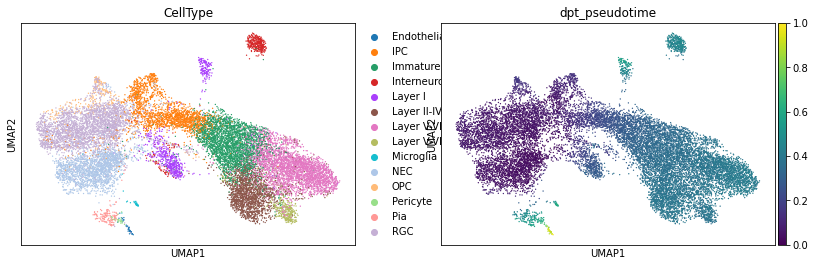

In [13]:
# after integration
ad_g.uns['iroot'] = np.flatnonzero(ad_g.obs['CellType']  == 'NEC')[0]
sc.tl.dpt(ad_g)

ad_g.obs['typeid'] = ad_g.obs['CellType'].cat.codes.astype('category')

sc.pl.umap(ad_g, color=['CellType', 'dpt_pseudotime'])

# Spearman corration between raw datasets and corrected datasets.

In [14]:
from scipy.stats import pearsonr, spearmanr

def compute_corr(adata_r_a, adata_r_b, adata_int, name, corr_method='pearson'):
    corr_f = pearsonr if corr_method=='pearson' else spearmanr
    
    # dataset A
    df_A = pd.DataFrame(columns=['raw', name])

    raw_non_inf_idx = adata_r_a.obs['dpt_pseudotime']!=np.inf
    int_non_inf_idx = adata_int[adata_r_a.obs_names].obs['dpt_pseudotime']!=np.inf

    non_inf = np.logical_and(raw_non_inf_idx, int_non_inf_idx) 
    
    print('dataset A', corr_f(adata_r_a.obs['dpt_pseudotime'][non_inf], adata_int[adata_r_a.obs_names].obs['dpt_pseudotime'][non_inf]))
    df_A['raw'] = adata_r_a.obs['dpt_pseudotime'][non_inf]
    df_A[name] = adata_int[adata_r_a.obs_names].obs['dpt_pseudotime'][non_inf]

    # dataset B
    df_B = pd.DataFrame(columns=['raw', name])
    raw_non_inf_idx = adata_r_b.obs['dpt_pseudotime']!=np.inf
    int_non_inf_idx = adata_int[adata_r_b.obs_names].obs['dpt_pseudotime']!=np.inf

    non_inf = np.logical_and(raw_non_inf_idx, int_non_inf_idx) 
    print('dataset B', corr_f(adata_r_b.obs['dpt_pseudotime'][non_inf], adata_int[adata_r_b.obs_names].obs['dpt_pseudotime'][non_inf]))
    df_B['raw'] = adata_r_b.obs['dpt_pseudotime'][non_inf]
    df_B[name] = adata_int[adata_r_b.obs_names].obs['dpt_pseudotime'][non_inf]
    return df_A, df_B
    
def save_corr_plt(df_A, df_B, name):
#     save_dir = '/home/yxh/gitrepo/clMining/GLOBE_updated/Figures'
    plt.scatter(df_A['raw'], df_A[name], s=.25)
    plt.grid(False)

    plt.xticks([0, 0.5, 1.])
    plt.yticks([0, 0.5, 1.])
#     plt.savefig(join(save_dir, f'A_pseudotime_{name}.png'))
    plt.show()
    
    plt.scatter(df_B['raw'], df_B[name], s=.25)
    plt.grid(False)

    plt.xticks([0, 0.5, 1.])
    plt.yticks([0, 0.5, 1.])
#     plt.savefig(join(save_dir, f'B_pseudotime_{name}.png'))
    plt.show()


dataset A SpearmanrResult(correlation=0.9305683122935714, pvalue=0.0)
dataset B SpearmanrResult(correlation=0.9378960917153695, pvalue=0.0)


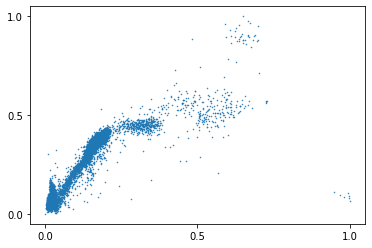

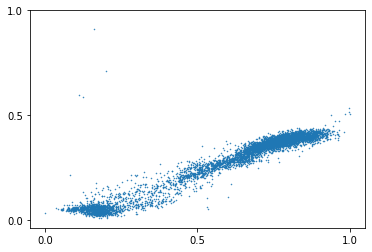

In [15]:
# for globe
df_A, df_B = compute_corr(adata_r_a, adata_r_b, ad_g, 'globe', corr_method='spearman')
save_corr_plt(df_A, df_B, 'globe')